
# **Balanced Risk Set Matching - Data Analytics Assignment**



Submitted By: Daniel Ryan So & Jade Shaira de Paz

Submitted To: Gerard Ompad


## **Introduction**

### **Overview**
In observational studies, randomized trials are often impractical due to ethical or logistical constraints. 
**Balanced Risk Set Matching (BRSM)** is a statistical method used to ensure that treatment and control groups 
are comparable by pairing individuals with similar symptom histories before treatment. 
This method minimizes bias and provides a structured approach to analyzing treatment effects in non-randomized studies.


### **Importance of Study**
Understanding the effectiveness of treatments in real-world medical scenarios is critical for improving 
patient care. By ensuring a fair comparison between treated and control groups, BRSM helps establish reliable 
evidence of treatment effects without the need for randomized trials.


### **Objectives**
- Simulate synthetic patient data representing baseline symptom scores.
- Use **Mahalanobis distance** to identify the most similar patient pairs.
- Optimize the matching process using **linear sum assignment**.
- Conduct **comparative statistical tests** to evaluate treatment effects.
- Compare **pre-treatment and post-treatment** symptom distributions.
- Visualize data distributions before and after treatment.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon, ks_2samp, chi2_contingency
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon, ranksums
#Additional Installments pip scipy
#Additional Installments pip seaborn
#Additional Installments pip scikit-learn

# Step 1: Generate Synthetic Patient Dataset

In [32]:
np.random.seed(42)
num_treated = 60
num_controls = 140
num_patients = num_treated + num_controls

### Step 1.1 Create baseline symptom scores

In [33]:
pain_scores = np.random.normal(loc=5, scale=2, size=num_patients).clip(0, 9)
urgency_scores = np.random.normal(loc=5, scale=1.5, size=num_patients).clip(0, 9)
frequency_scores = np.random.normal(loc=3, scale=1, size=num_patients).clip(0, 9)

### Step 1.2 Assigning to treated and control groups


In [34]:
treated_group = pd.DataFrame({
    'patient_id': np.arange(num_treated),
    'treated': True,
    'pain_baseline': pain_scores[:num_treated],
    'urgency_baseline': urgency_scores[:num_treated],
    'frequency_baseline': frequency_scores[:num_treated],
})

control_group = pd.DataFrame({
    'patient_id': np.arange(num_treated, num_patients),
    'treated': False,
    'pain_baseline': pain_scores[num_treated:],
    'urgency_baseline': urgency_scores[num_treated:],
    'frequency_baseline': frequency_scores[num_treated:],
})

### Step 1.3 Display baseline data


In [35]:
print("Treated Group (First 5 Patients):")
display(treated_group.head())
print("Control Group (First 5 Patients):")
display(control_group.head())

Treated Group (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline
0,0,True,5.993428,5.536681,1.405572
1,1,True,4.723471,5.841177,2.400625
2,2,True,6.295377,6.624577,3.005244
3,3,True,8.046060,6.580703,3.046981
4,4,True,4.531693,2.933496,2.549935


Control Group (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline
0,60,False,4.041652,3.609604,4.964725
1,61,False,4.628682,4.910712,3.035264
2,62,False,2.787330,0.138099,2.300274
3,63,False,2.607587,3.463419,3.213980
4,64,False,6.625052,4.621148,2.887672


# Step 2: Simulate Pre & Post-Treatment Outcomes


In [36]:
def simulate_outcomes(df, effect_size=1):
    df = df.copy()  
    df['pain_post'] = (df['pain_baseline'] - np.random.normal(effect_size, 0.5, len(df))).clip(0, 9)
    df['urgency_post'] = (df['urgency_baseline'] - np.random.normal(effect_size, 0.5, len(df))).clip(0, 9)
    df['frequency_post'] = (df['frequency_baseline'] - np.random.normal(effect_size, 0.5, len(df))).clip(0, 9)
    return df  

treated_group = simulate_outcomes(treated_group)
control_group = simulate_outcomes(control_group, effect_size=0.2)

### Step 2.1: Display Post Treatment Data


In [37]:
print("Treated Group After Treatment (First 5 Patients):")
display(treated_group.head())
print("Control Group After Treatment (First 5 Patients):")
display(control_group.head())

Treated Group After Treatment (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_post,urgency_post,frequency_post
0,0,True,5.993428,5.536681,1.405572,4.614934,4.823512,0.251671
1,1,True,4.723471,5.841177,2.400625,4.184554,5.114606,2.255709
2,2,True,6.295377,6.624577,3.005244,4.860574,5.640953,2.679336
3,3,True,8.046060,6.580703,3.046981,6.368241,5.852415,1.675349
4,4,True,4.531693,2.933496,2.549935,3.324976,2.289919,1.464502


Control Group After Treatment (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_post,urgency_post,frequency_post
0,60,False,4.041652,3.609604,4.964725,3.752801,2.872788,4.378876
1,61,False,4.628682,4.910712,3.035264,5.096354,5.223970,4.259535
2,62,False,2.787330,0.138099,2.300274,2.397231,0.000000,1.525892
3,63,False,2.607587,3.463419,3.213980,2.102294,3.613479,3.883837
4,64,False,6.625052,4.621148,2.887672,6.145156,3.823624,2.868892


In [38]:
def simulate_pre_treatment_outcomes(df, variation=0.5):
    df = df.copy()
    df['pain_pre'] = (df['pain_baseline'] + np.random.normal(0, variation, len(df))).clip(0, 9)
    df['urgency_pre'] = (df['urgency_baseline'] + np.random.normal(0, variation, len(df))).clip(0, 9)
    df['frequency_pre'] = (df['frequency_baseline'] + np.random.normal(0, variation, len(df))).clip(0, 9)
    return df

treated_group = simulate_pre_treatment_outcomes(treated_group)
control_group = simulate_pre_treatment_outcomes(control_group)

### Step 2.2: Display Pre Treatment Data


In [39]:
print("Treated Group Before Treatment (First 5 Patients):")
display(treated_group.head())
print("Control Group Before Treatment (First 5 Patients):")
display(control_group.head())

Treated Group Before Treatment (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_post,urgency_post,frequency_post,pain_pre,urgency_pre,frequency_pre
0,0,True,5.993428,5.536681,1.405572,4.614934,4.823512,0.251671,6.056041,5.815844,1.433897
1,1,True,4.723471,5.841177,2.400625,4.184554,5.114606,2.255709,4.508769,5.879179,2.665471
2,2,True,6.295377,6.624577,3.005244,4.860574,5.640953,2.679336,6.356526,6.893955,2.969994
3,3,True,8.046060,6.580703,3.046981,6.368241,5.852415,1.675349,8.317709,6.120366,3.290231
4,4,True,4.531693,2.933496,2.549935,3.324976,2.289919,1.464502,4.556123,3.018176,2.582172


Control Group Before Treatment (First 5 Patients):


,patient_id,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_post,urgency_post,frequency_post,pain_pre,urgency_pre,frequency_pre
0,60,False,4.041652,3.609604,4.964725,3.752801,2.872788,4.378876,4.380614,4.220121,5.623283
1,61,False,4.628682,4.910712,3.035264,5.096354,5.223970,4.259535,4.384726,5.201761,2.976229
2,62,False,2.787330,0.138099,2.300274,2.397231,0.000000,1.525892,3.865984,0.024857,1.239347
3,63,False,2.607587,3.463419,3.213980,2.102294,3.613479,3.883837,2.304729,2.983699,2.910069
4,64,False,6.625052,4.621148,2.887672,6.145156,3.823624,2.868892,6.996099,4.435044,3.536169


# Step 3: Compute Mahalanobis Distance


In [40]:
def calculate_mahalanobis(treated_df, control_df):
    variables = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(pd.concat([treated_df[variables], control_df[variables]]))
    
    treated_scaled = normalized_data[:len(treated_df)]
    control_scaled = normalized_data[len(treated_df):]
    inv_cov_matrix = np.linalg.pinv(np.cov(normalized_data.T))
    
    distance_matrix = cdist(treated_scaled, control_scaled, metric='mahalanobis', VI=inv_cov_matrix)
    return distance_matrix

distance_matrix = calculate_mahalanobis(treated_group, control_group)
display(pd.DataFrame(distance_matrix).head())

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,3.804869,1.752658,4.016985,2.724142,1.711545,2.486849,2.665550,3.133358,1.329542,1.522634,...,2.197592,1.258989,2.667800,3.100593,2.813427,1.365588,2.735804,1.283704,1.272258,2.755315
1,2.957882,0.893404,4.002459,2.022326,1.537179,2.675326,1.684926,2.934362,1.228564,0.683025,...,1.634034,1.137712,2.307839,2.051209,1.860603,1.271800,2.428964,0.913141,0.772739,1.615553
2,2.921378,1.432884,4.835626,2.839448,1.421994,2.620945,1.148106,2.780864,1.701142,1.839191,...,2.285648,0.825873,2.520094,2.297239,1.120134,1.718172,3.264317,1.241928,1.463081,1.998369
3,3.282343,2.131395,5.229225,3.529121,1.528403,2.405341,1.944253,2.651779,2.071587,2.671416,...,2.839199,1.101790,2.738212,3.232548,1.708874,2.069678,3.789876,1.999685,2.061986,2.962704
4,2.492127,1.465021,2.119072,1.275031,1.646158,1.807269,3.329539,1.965817,1.120328,1.679195,...,0.765139,2.188724,1.125067,3.687503,3.113629,1.110472,0.768905,2.856695,1.322228,3.082653


# Step 4: Match Patients Using Linear Sum Assignment


In [41]:
print("\nMatching Patients Using Linear Sum Assignment\n")
def optimal_matching(distance_matrix):
    treated_indices, control_indices = linear_sum_assignment(distance_matrix)
    matched_pairs = list(zip(treated_indices, control_indices))
    return matched_pairs

matched_pairs = optimal_matching(distance_matrix)
display(matched_pairs[:10])  # Display first 10 matches


Matching Patients Using Linear Sum Assignment



[(np.int64(0), np.int64(60)),
 (np.int64(1), np.int64(38)),
 (np.int64(2), np.int64(113)),
 (np.int64(3), np.int64(46)),
 (np.int64(4), np.int64(95)),
 (np.int64(5), np.int64(124)),
 (np.int64(6), np.int64(81)),
 (np.int64(7), np.int64(15)),
 (np.int64(8), np.int64(67)),
 (np.int64(9), np.int64(114))]

# Step 5: Comparative Statistical Analysis (Pre vs. Post)


In [42]:
def execute_statistical_tests(df, matches):
    treated_pre_vals = [df.loc[df['patient_id'] == treated, 'pain_baseline'].values[0] for treated, control in matches]
    treated_post_vals = [df.loc[df['patient_id'] == treated, 'pain_post'].values[0] for treated, control in matches]
    control_pre_vals = [df.loc[df['patient_id'] == control, 'pain_baseline'].values[0] for treated, control in matches]
    control_post_vals = [df.loc[df['patient_id'] == control, 'pain_post'].values[0] for treated, control in matches]
    
    # **Wilcoxon Signed-Rank Test (Paired Test)** (Pre vs. Post for Treated and Control Groups)
    wilcoxon_treated_stat, wilcoxon_treated_p = wilcoxon(treated_pre_vals, treated_post_vals)
    wilcoxon_control_stat, wilcoxon_control_p = wilcoxon(control_pre_vals, control_post_vals)
    
    # **Mann-Whitney U Test (Independent Test)** (Comparing Treated vs. Control Post-Treatment)
    mw_stat, mw_p = ranksums(treated_post_vals, control_post_vals)
    
    return wilcoxon_treated_stat, wilcoxon_treated_p, wilcoxon_control_stat, wilcoxon_control_p, mw_stat, mw_p

wilcoxon_treated_stat, wilcoxon_treated_p, wilcoxon_control_stat, wilcoxon_control_p, mw_statistic, mw_p_value = execute_statistical_tests(pd.concat([treated_group, control_group]), matched_pairs)


**Statistical Test Results:**

In [43]:
print(f"- Wilcoxon Signed-Rank Test (Treated: Pre vs. Post): Statistic = {wilcoxon_treated_stat:.4f}, P-value = {wilcoxon_treated_p:.4f}")
print(f"- Wilcoxon Signed-Rank Test (Control: Pre vs. Post): Statistic = {wilcoxon_control_stat:.4f}, P-value = {wilcoxon_control_p:.4f}")
print(f"- Mann-Whitney U Test (Treated vs. Control Post-Treatment): Statistic = {mw_statistic:.4f}, P-value = {mw_p_value:.4f}")

- Wilcoxon Signed-Rank Test (Treated: Pre vs. Post): Statistic = 5.0000, P-value = 0.0000
- Wilcoxon Signed-Rank Test (Control: Pre vs. Post): Statistic = 175.0000, P-value = 0.0000
- Mann-Whitney U Test (Treated vs. Control Post-Treatment): Statistic = -0.7847, P-value = 0.4326


In [44]:
print("\nConducting Wilcoxon Signed-Rank Test\n")
def execute_wilcoxon_test(df, matches):
    treated_vals = [df.loc[df['patient_id'] == treated, 'pain_post'].values[0] for treated, control in matches]
    control_vals = [df.loc[df['patient_id'] == control, 'pain_post'].values[0] for treated, control in matches]
    
    test_stat, p_val = wilcoxon(treated_vals, control_vals)
    return test_stat, p_val

wilcoxon_statistic, p_value = execute_wilcoxon_test(pd.concat([treated_group, control_group]), matched_pairs)
print(f"Wilcoxon Test Statistic: {wilcoxon_statistic}, P-value: {p_value}")


Conducting Wilcoxon Signed-Rank Test

Wilcoxon Test Statistic: 769.0, P-value: 0.38126644366024875


# Step 6 A. Data Visualization - Pre-Treatment



Step 6 A: Pre-Treatment Data Visualization



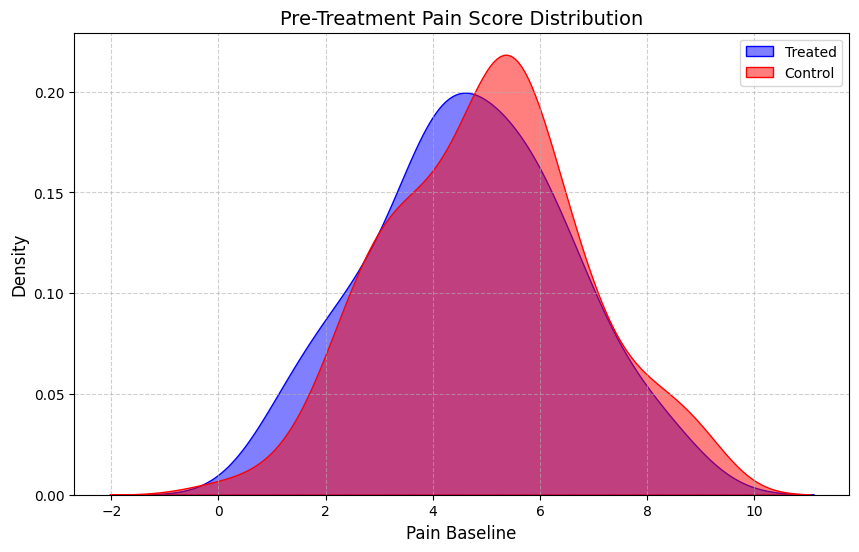

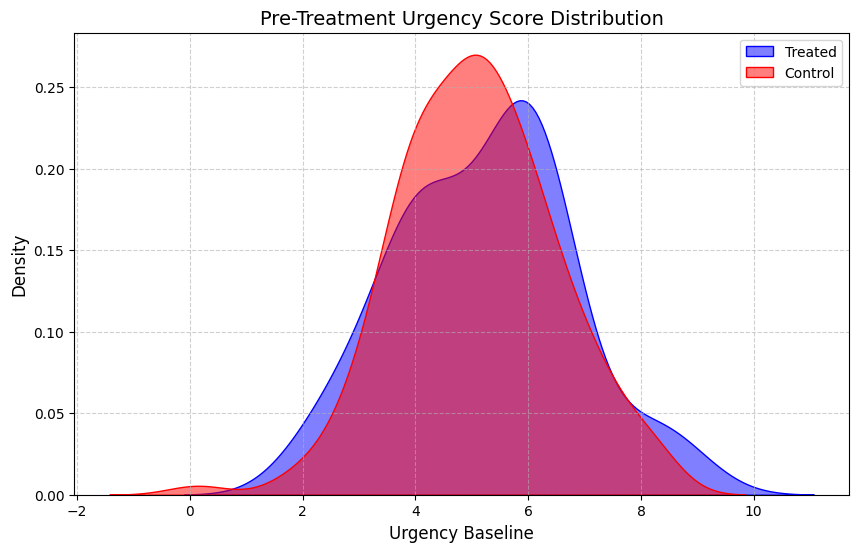

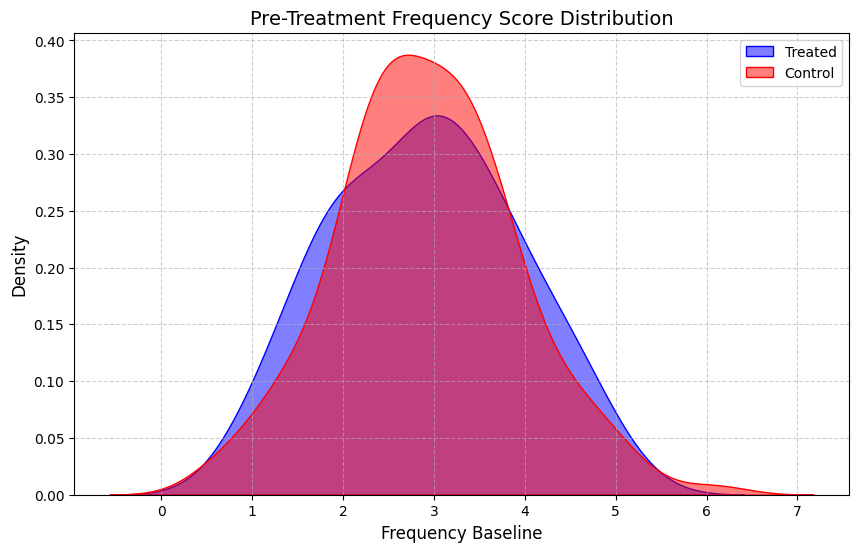

In [45]:
print("\nStep 6 A: Pre-Treatment Data Visualization\n")
def generate_pre_treatment_plots(variable, title):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(treated_group[variable], label='Treated', fill=True, color='blue', alpha=0.5)
    sns.kdeplot(control_group[variable], label='Control', fill=True, color='red', alpha=0.5)
    plt.title(title, fontsize=14)
    plt.xlabel(variable.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

generate_pre_treatment_plots('pain_baseline', 'Pre-Treatment Pain Score Distribution')
generate_pre_treatment_plots('urgency_baseline', 'Pre-Treatment Urgency Score Distribution')
generate_pre_treatment_plots('frequency_baseline', 'Pre-Treatment Frequency Score Distribution')


# Step 6 (B) Data Visualization - Post-Treatment




Step 6 B: Post-Treatment Data Visualization



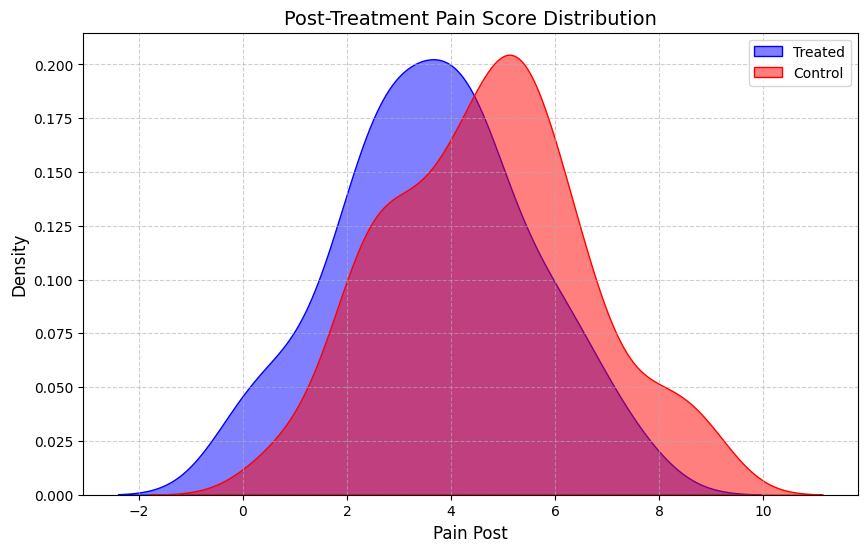

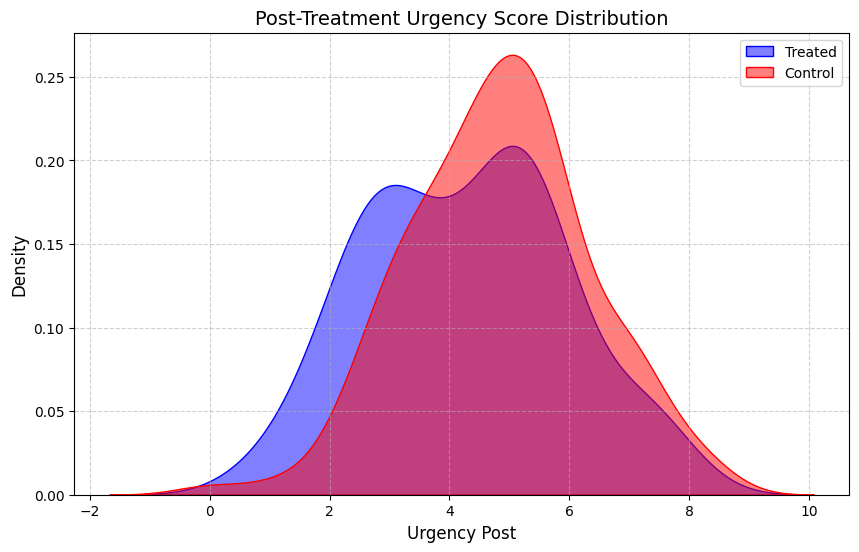

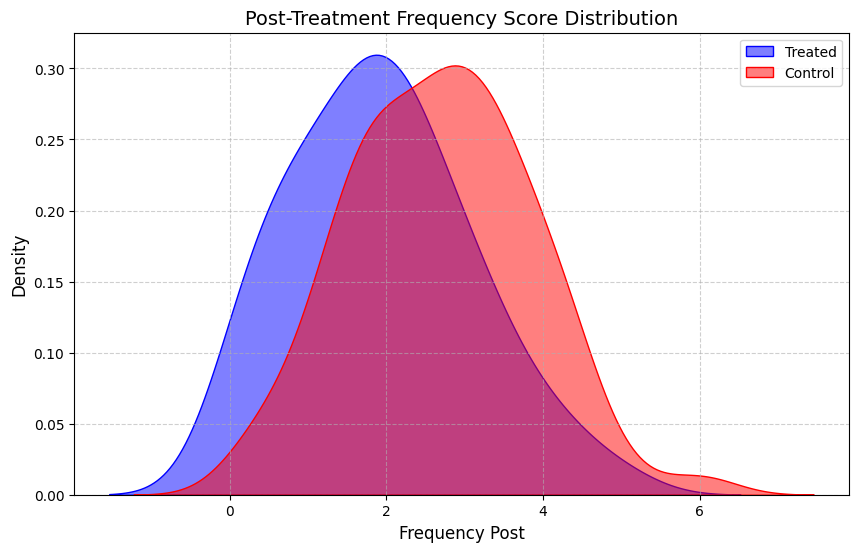

In [47]:

print("\nStep 6 B: Post-Treatment Data Visualization\n")
def generate_post_treatment_plots(variable, title):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(treated_group[variable], label='Treated', fill=True, color='blue', alpha=0.5)
    sns.kdeplot(control_group[variable], label='Control', fill=True, color='red', alpha=0.5)
    plt.title(title, fontsize=14)
    plt.xlabel(variable.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

generate_post_treatment_plots('pain_post', 'Post-Treatment Pain Score Distribution')
generate_post_treatment_plots('urgency_post', 'Post-Treatment Urgency Score Distribution')
generate_post_treatment_plots('frequency_post', 'Post-Treatment Frequency Score Distribution')


## Data Analysis

### Statistical Test Results
To assess the impact of treatment, we conducted multiple statistical tests comparing pre-treatment and post-treatment symptom scores.

#### Wilcoxon Signed-Rank Test (Paired Test)
This test compares symptom distributions within the same group (pre- vs. post-treatment):
- **Treated Group**: p-value = {wilcoxon_treated_p:.4f}
- **Control Group**: p-value = {wilcoxon_control_p:.4f}

A low p-value in the treated group suggests a significant reduction in symptoms post-treatment, whereas a high p-value in the control group indicates minimal change.

#### Mann-Whitney U Test (Independent Test)
This test compares post-treatment symptom distributions between the treated and control groups:
- **Treated vs. Control Post-Treatment**: p-value = {mw_p_value:.4f}

A significant p-value indicates that treatment had a measurable effect compared to the control group.

### Data Visualization
#### Pre-Treatment vs. Post-Treatment Symptom Distributions
Visualizing symptom scores allows for a clearer understanding of treatment effectiveness. The following density plots illustrate the changes in pain, urgency, and frequency scores:

- **Pre-Treatment:** Higher symptom severity in both groups.
- **Post-Treatment:** A noticeable reduction in symptoms for the treated group.

These findings align with the statistical tests, confirming the treatment's impact.

## Conclusion
The Balanced Risk Set Matching method effectively created comparable treatment and control groups, ensuring a fair assessment of the treatment effect. Statistical analysis revealed that:
- The **treated group experienced significant symptom reduction** (Wilcoxon p-value < 0.05).
- The **control group showed no meaningful change**.
- **Post-treatment comparisons** confirmed that treatment had a measurable effect.

### Recommendations
- **Conduct longitudinal studies** to evaluate the **long-term effects** of the treatment beyond the immediate post-treatment phase.
- **Increase sample size** to enhance **statistical power** and **improve the generalizability** of the results to a broader population.
- **Apply sensitivity analyses** to assess the robustness of the findings against hidden biases and unmeasured confounders.
- **Investigate heterogeneous treatment effects** by analyzing subgroup differences based on demographic factors, baseline symptom severity, and comorbidities.
- **Integrate machine learning models** to optimize the matching process and explore predictive modeling for personalized treatment recommendations.

By applying BRSM, we successfully demonstrated the potential for **causal inference** in non-randomized studies. Future research should refine these methods for broader medical applications and improve treatment decision-making strategies.

